# Backtest
In this section, I will backtest an investment strategy that enters Draftkings DFS contests based on my player statistic projections. I *temporarily* limit the backtest to Draftkings contests due to the current lack of data on the historical results of DFS contests on other sites. The methods that determine which contests I will enter and the lineups that enter each contest will be explored in this notebook. 

## Setup

Import the necessary libraries.

In [1]:
# for data
from pyNBA.Data.constants import ROTO_NAME_TO_NBA_NAME, DB_TEAM_TO_NBA_TEAM, BAD_CONTEST_SUBSTRINGS, OWNERSHIP_NAME_TO_NBA_NAME
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import pandas as pd
import numpy as np
from numpy.random import normal
from datetime import datetime, timedelta

# for models
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site
from pyNBA.Models.fantasy_points import FPModel
from pyNBA.Models.variance import VarianceModel
from pyNBA.Models.ownership import OwnershipModel
from pyNBA.Models.top_score import TopScoreModel
import pulp
from pydfs_lineup_optimizer.solvers.pulp_solver import PuLPSolver

# for backtesting
from pyNBA.Models.features import FeatureCreation
import time
from pydfs_lineup_optimizer import get_optimizer, Sport
from pydfs_lineup_optimizer import Player
from numpy.random import normal
from numpy.random import choice
import scipy.stats as st
import random
from random import sample
from collections import Counter
import bisect

# for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from datetime import datetime
import seaborn as sns; sns.set()

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Data
Collect all data necessary to perform the backtest.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

# historical DFS salary data
salary_data = query_data.query_salary_data()
salary_data = salary_data.rename(columns={'POSITION': 'DFS_POSITION'})
salary_data['NAME'] = salary_data['PLAYER'].apply(clean_data.roto_name_to_nba_name)

# historical DFS contest data. I am only interested in predicting ownership in Classic GPP compeititions.
contest_data = query_data.query_contest_data()
contest_data['MAXROI'] = contest_data['TOPPRIZE']/contest_data['ENTRYFEE']
contest_data = contest_data.loc[
    (contest_data['SLATETYPE'] == 'Classic') & (contest_data['CASHLINE'] > 200) & (contest_data['MAXROI'] > 2) &
    (~contest_data['CONTESTNAME'].str.lower().str.contains('|'.join(BAD_CONTEST_SUBSTRINGS)))
].dropna(subset=['CASHLINE'])

# contest payout structure
contest_info = query_data.query_contest_info_data()

# historical player ownership
ownership_data = query_data.query_ownership_data()
ownership_data['NAME'] = ownership_data['PLAYERNAME'].apply(
    lambda x: x if x not in OWNERSHIP_NAME_TO_NBA_NAME else OWNERSHIP_NAME_TO_NBA_NAME[x]
    )

# historical vegas odds data
odds_data = query_data.query_odds_data()

# historical quarterly boxscore data
quarterly_boxscore_data = query_data.query_quarterly_boxscore_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


## Strategy
Determine viable contests and how to enter each contest.

Initilize data.

In [3]:
season_list = list(boxscores['SEASON'].unique())

# to calculate fantasy points
DKFPCalculator = FPCalculator(Site.DRAFTKINGS)

# isolate Draftkings salaries
boxscores['REB'] = boxscores['DREB'] + boxscores['OREB']
    
# optimize Draftkings NBA lineups
class CustomPuLPSolver(PuLPSolver):
    LP_SOLVER = pulp.GLPK_CMD(msg=0)
optimizer = get_optimizer(Site.DRAFTKINGS, Sport.BASKETBALL, solver=CustomPuLPSolver)

Helper Functions.

In [4]:
def get_contest_prize(contest_info, score):
    prize = contest_info.loc[contest_info['MINPOINTS'] <= score, 'PRIZE'].max()
    return prize

def get_complete_positions(position_list):
    if bool(set(position_list).intersection(['PG', 'SG'])):
        position_list.append('G')
    if bool(set(position_list).intersection(['SF', 'PF'])):
        position_list.append('F')
    position_list.append('U')
    return position_list

def first_valid_position(l1, l2):
    for i in l1:
        if i not in l2:
            return l2 | {i}
        
def get_n_opponent_generations(max_contest_total_entries):
    if max_contest_total_entries < 10000:
        return 3.5
    elif max_contest_total_entries < 50000:
        return 2.5
    elif max_contest_total_entries < 100000:
        return 1.5
    else: 
        return 1
    
def get_prizes(my_scores, opponent_scores, n_opponent_scores, rank_to_prize, entry_fee):
    my_prizes = []

    prev_rank = 0
    for my_score in my_scores:
        if prev_rank == n_opponent_scores:
            my_prizes.append(0 - entry_fee)
        else:
            rank = prev_rank + bisect.bisect_left(opponent_scores[prev_rank:], my_score)
            prize = rank_to_prize[rank+1] if rank+1 in rank_to_prize else 0
            my_prizes.append(prize - entry_fee)
            prev_rank = rank
    
    return my_prizes

Enter contests.

In [ ]:
print(time.ctime())

max_entry_fee_per_contest = 1000
max_entry_fee = 250
randomness_factor = 2.5cu
min_salary = 49200
salary_room = 1000
n_opponent_split = 3
max_n_samples = 5
max_player_std = 2
n_simulations = 1500
timeout_minutes = 10

results = pd.DataFrame(columns = [
    'DATE', 'GAME_COUNT', 'CONTEST_TYPE', 'MAX_ENTRIES', 'TOTAL_ENTRIES',
    'ENTRY_FEE', 'CASHLINE', 'SCORE', 'TOP_SCORE', 'PRIZE', 'TOP_PRIZE'
])
pnl = 0

for i in range(1, len(season_list)):
    print(season_list[i])
    fp_train_data = boxscores.loc[boxscores['SEASON'].isin(season_list[0:i])]
    ownership_train_data = boxscores.loc[~(boxscores['SEASON'] == season_list[i])]
    test_data = boxscores.loc[boxscores['SEASON'] == season_list[i]]

    # projected contest top scores
    contest_test_data = contest_data.loc[
        (contest_data['DATE'] >= test_data['DATE'].min()) & (contest_data['DATE'] <= test_data['DATE'].max())
    ]
    contest_train_data = contest_data.loc[
        ~((contest_data['DATE'] >= test_data['DATE'].min()) & (contest_data['DATE'] <= test_data['DATE'].max()))
    ]
    if contest_test_data.empty:
        continue

    # projected fantasy points
    fp_model = FPModel(fp_train_data, test_data, Site.DRAFTKINGS)
    fp_model.train_model(quarterly_boxscore_data, odds_data)
    predictions, fp_hat_column = fp_model.predict()
    predictions = predictions.dropna(subset=[fp_hat_column])

    # actual fantasy points
    predictions['DKFP'] = predictions.apply(
        lambda x: DKFPCalculator.calculate_fantasy_points(
            x['SEASON'], x['PTS'], x['REB'], x['AST'], x['TOV'], x['BLK'], x['STL'], x['FG3M']
        ), 
        axis=1
    )

    # fantasy point variance
    variance_model = VarianceModel(predictions)
    predictions, variance_column = variance_model.predict('DKFP')
    pct_variance_column = 'RESIDUAL_PCT'
    predictions[pct_variance_column] = predictions[variance_column]/predictions[fp_hat_column]
    predictions[pct_variance_column] = predictions[pct_variance_column].replace([np.inf, -np.inf], np.nan)
    predictions[pct_variance_column] = predictions[pct_variance_column].fillna(0.35)
    predictions[pct_variance_column] = predictions[pct_variance_column].clip(lower=0.15)

    # projected ownership
    ownership_model = OwnershipModel(ownership_train_data, test_data, Site.DRAFTKINGS)
    ownership_model.create_features(salary_data, contest_data, ownership_data, odds_data)
    ownership_model.train_model()
    ownership_predictions, ownership_column = ownership_model.predict()

    # merge projections to data
    dk_salary_data = salary_data.loc[salary_data['SITE'] == Site.DRAFTKINGS]
    predictions = predictions.merge(dk_salary_data, on=['DATE', 'NAME'], how='left')
    predictions = predictions.dropna(subset=['SALARY', 'DFS_POSITION'])

    ownership_predictions = ownership_predictions.merge(
        predictions[['DATE', 'NAME', fp_hat_column, pct_variance_column, 'SALARY']],
        on=['DATE', 'NAME'], how='left'
    )

    print(time.ctime())

    # iterate through each slate in the season
    a = contest_test_data.loc[contest_test_data['TOTALENTRIES'] <= 250000].sort_values(by='DATE')
    for (date, slate_id), slate_contest_data in a.groupby(['DATE', 'SLATEID']):
        print(time.ctime(), date, slate_id)

        # get players in slate
        slate_teams = slate_contest_data.iloc[0]['TEAMS'].split('_')
        slate_teams = [i if i not in DB_TEAM_TO_NBA_TEAM else DB_TEAM_TO_NBA_TEAM[i] for i in slate_teams]
        board = predictions.loc[
            (predictions['DATE'] == date) &
            (predictions['TEAM'].isin(slate_teams))
        ]

        board_teams = list(board['TEAM'].unique())
        game_count = slate_contest_data.iloc[0]['GAMECOUNT']
        sym_dif = (set(board_teams).symmetric_difference(set(slate_teams)))
        if bool(sym_dif) or len(slate_teams) != game_count*2:
            print('ERROR: MISSING TEAM DATA')
            continue

        slate_ownership_predictions = ownership_predictions.loc[ownership_predictions['SLATEID'] == slate_id]
        slate_board = slate_ownership_predictions[['DATE', 'NAME', ownership_column]].merge(board, on=['DATE', 'NAME'], how='left')
        slate_board = slate_board.dropna(subset=['SALARY', 'DFS_POSITION', fp_hat_column, pct_variance_column, ownership_column])
        ownership_sum = slate_board[ownership_column].sum()
        slate_board[ownership_column] = slate_board[ownership_column].map(lambda x: 8*x/ownership_sum)
            
        # generate opponent lineups for slate
        max_contest_total_entries = slate_contest_data['TOTALENTRIES'].max()
        opponent_players = slate_board.loc[slate_board[ownership_column]*max_contest_total_entries >= 1]
        opponent_players['DFS_POSITIONS'] = opponent_players['DFS_POSITION'].map(lambda x: x.split('_'))
        opponent_players['DFS_POSITIONS'] = opponent_players['DFS_POSITIONS'].map(lambda x: get_complete_positions(x))

        player_counter = Counter()
        max_salary = opponent_players['SALARY'].max()
        n_opponent_generations = get_n_opponent_generations(max_contest_total_entries)
        n_rows = int(max_contest_total_entries/n_opponent_split)
        prev_n_valid_opponent_lineups = 0

        all_opponent_lineups = pd.DataFrame()
        min_lineups = n_opponent_generations*max_contest_total_entries
        end_time = datetime.now() + timedelta(minutes=timeout_minutes)
        while len(all_opponent_lineups) < min_lineups and datetime.now() < end_time:
            opponent_lineups = pd.DataFrame(
                {'PLAYERIDS': np.nan, 'SPOTS_REMAINING': 8, 'POSITIONS_FILLED': np.nan, 'SALARY_REMAINING': 50000},
                index = [i for i in range(n_rows)]
            )
            opponent_lineups['PLAYERIDS'] = [list()] * len(opponent_lineups)
            opponent_lineups['POSITIONS_FILLED'] = [set()] * len(opponent_lineups)
            n_opponent_lineups = len(opponent_lineups)
            
            if prev_n_valid_opponent_lineups == 0:
                opponent_players = opponent_players.sample(frac=1)
            else:
                opponent_players['COUNT'] = opponent_players['PLAYERID'].map(lambda x: player_counter[x])
                opponent_players['EXPECTED_COUNT'] = opponent_players[ownership_column]*len(all_opponent_lineups)
                opponent_players['REP'] = opponent_players['COUNT'] - opponent_players['EXPECTED_COUNT']
                opponent_players = opponent_players.sort_values(by='REP')
            for _, player in opponent_players.iterrows():
                valid_indexes = opponent_lineups.loc[
                    ~(opponent_lineups['POSITIONS_FILLED'].map(set(player['DFS_POSITIONS']).issubset)) &
                    (opponent_lineups['SALARY_REMAINING'] > player['SALARY']) & 
                    (opponent_lineups['SALARY_REMAINING'] - (opponent_lineups['SPOTS_REMAINING']-1)*max_salary - salary_room < player['SALARY'])
                ].index.to_list()
                n = len(valid_indexes)
                len_subset = int(min(n, (n_rows*player[ownership_column])))

                subset = sample(valid_indexes, len_subset)
                opponent_lineups.loc[subset, 'PLAYERIDS'] = opponent_lineups.loc[subset, 'PLAYERIDS'].map(lambda x: x + [player['PLAYERID']])
                opponent_lineups.loc[subset, 'SPOTS_REMAINING'] -= 1
                opponent_lineups.loc[subset, 'POSITIONS_FILLED'] = opponent_lineups.loc[subset, 'POSITIONS_FILLED'].map(
                    lambda x: first_valid_position(player['DFS_POSITIONS'], x)
                )  
                opponent_lineups.loc[subset, 'SALARY_REMAINING'] -= player['SALARY']

            valid_opponent_lineups = opponent_lineups.loc[opponent_lineups['SPOTS_REMAINING'] == 0]
            finished_lineups = valid_opponent_lineups['PLAYERIDS'].to_list()
            for lineup in finished_lineups:
                for player in lineup:
                    player_counter[player] += 1
            
            prev_n_valid_opponent_lineups = len(valid_opponent_lineups)
            all_opponent_lineups = all_opponent_lineups.append(valid_opponent_lineups)
            
        if len(all_opponent_lineups) < min_lineups:
            print('COULD NOT GENERATE {} OPPONENT LINEUPS'.format(min_lineups), time.ctime())
            continue

        print('GENERATED {} OPPONENT LINEUPS'.format(min_lineups), time.ctime())

        # generate potential lineups for slate
        players = []
        for _, player in slate_board.iterrows():
            player_id = player['PLAYERID']
            name = player['NAME'].split()
            first_name = name[0]
            last_name = name[1] if len(name) > 1 else ''
            positions = player['DFS_POSITION'].split('_')
            team = player['TEAM']
            mu = player[fp_hat_column]
            salary =  player['SALARY']
            std = player[pct_variance_column]*(1 - player[ownership_column])

            player = Player(player_id, first_name, last_name, positions, team, salary, mu, standard_deviation=std/randomness_factor)
            players.append(player)

        optimizer.load_players(players)
        optimizer.set_max_deviation(randomness_factor)
        optimizer.set_min_salary_cap(min_salary)

        total_max_entries = slate_contest_data['MAXENTRIES'].sum()
        n = int(max(2.5*total_max_entries, 500))
        lineups = optimizer.optimize(n=n, randomness=True)
        
        potential_lineups = pd.DataFrame()
        try:
            for lineup in lineups:
                player_ids = [i.id for i in lineup.lineup]
                real_score = slate_board.loc[slate_board['PLAYERID'].isin(player_ids), 'DKFP'].sum()
                potential_lineups = potential_lineups.append(
                    pd.DataFrame({'PLAYERIDS': [player_ids], 'REALSCORE': [real_score]})
                )
        except:
            print('ERROR: COULD NOT GENERATE LINEUPS')
            continue
            
        print('GENERATED {} POTENTIAL LINEUPS'.format(n), time.ctime())

        # iterate through each contest in the slate
        slate_contest_data = slate_contest_data.loc[
            (slate_contest_data['ENTRYFEE'] <= max_entry_fee) & (slate_contest_data['ENTRYFEE'] > 1)
        ].sort_values(by='ENTRYFEE', ascending=False)
        for _, contest in slate_contest_data.iterrows():
            contest_id = contest['CONTESTID']
            contest_total_entries = contest['TOTALENTRIES']
            contest_max_entries = contest['MAXENTRIES']
            contest_entry_fee = contest['ENTRYFEE']
            
            result = {} 
            result['DATE'] = date
            result['GAME_COUNT'] = game_count
            result['MAX_ENTRIES'] = contest_max_entries
            result['TOTAL_ENTRIES'] = contest_total_entries
            result['ENTRY_FEE'] = contest_entry_fee
            result['CASHLINE'] = contest['CASHLINE']
            result['TOP_PRIZE'] = contest['TOPPRIZE']
            result['TOP_SCORE'] = contest['TOPSCORE']

            # simulate winnings
            entered_contest_info = contest_info.loc[contest_info['CONTESTID'] == contest_id]
            entered_contest_info['MINPOINTS'] = entered_contest_info['MINPOINTS'].fillna(0)
            rank_to_prize = {}
            prev_i = 0
            prev_prize = 0
            for _, row in entered_contest_info.loc[entered_contest_info['PRIZE'] > 0].iterrows():
                min_rank = int(row['MINRANK'])
                max_rank = int(row['MAXRANK'])
                prize = row['PRIZE']
                for i in range(prev_i+1, min_rank):
                    rank_to_prize[i] = (prize + prev_prize)/2
                for i in range(min_rank, max_rank+1):
                    rank_to_prize[i] = prize
                prev_i = i
                prev_prize = prize

            potential_lineups['WINNINGS'] = 0
            n_samples = int(min(max_n_samples, round(len(all_opponent_lineups)/contest_total_entries)))
            n_simulations_per_sample = int(n_simulations/n_samples)
            for i in range(n_samples):
                opponent_sample = all_opponent_lineups.sample(contest_total_entries)
                for i in range(n_simulations_per_sample):
                    slate_board['SAMPLE'] = slate_board[fp_hat_column]*(1 + normal(0, slate_board[pct_variance_column]))
                    player_performance = slate_board.set_index('PLAYERID')['SAMPLE'].to_dict()

                    opponent_sample['SAMPLE_SCORE'] = opponent_sample['PLAYERIDS'].map(lambda x: -1*sum([player_performance[i] for i in x]))
                    opponent_scores = np.sort(opponent_sample['SAMPLE_SCORE'].to_numpy())[:max_rank]

                    potential_lineups['SAMPLE_SCORE'] = potential_lineups['PLAYERIDS'].map(lambda x: -1*sum([player_performance[i] for i in x]))
                    potential_lineups = potential_lineups.sort_values(by='SAMPLE_SCORE')
                    my_scores = potential_lineups['SAMPLE_SCORE'].to_numpy()

                    prizes = get_prizes(my_scores, opponent_scores, max_rank, rank_to_prize, contest_entry_fee)
                    potential_lineups['WINNINGS'] += prizes

            # enter best lineups
            potential_lineups = potential_lineups.sort_values(by='WINNINGS', ascending=False)
            n_entries = int(min(contest_max_entries, max_entry_fee_per_contest/contest_entry_fee))
            best_lineups = potential_lineups.loc[potential_lineups['WINNINGS'] > 0].head(n_entries)
            n_best_lineups = len(best_lineups)
            potential_lineups = potential_lineups[n_best_lineups:]
            current_pnl = 0
            for _, lineup in best_lineups.iterrows():
                score = lineup['REALSCORE']
                prize = get_contest_prize(entered_contest_info, score)
                
                result['SCORE'] = score
                result['PRIZE'] = prize
                results = results.append(result, ignore_index=True)
                
                contest_pnl = prize - contest_entry_fee
                if not np.isnan(contest_pnl):
                    current_pnl += (prize - contest_entry_fee)

            pnl += current_pnl
            pnl = round(pnl, 2)
            print('{} ({})'.format(str(pnl), str(current_pnl)))


Plot overall PNL.

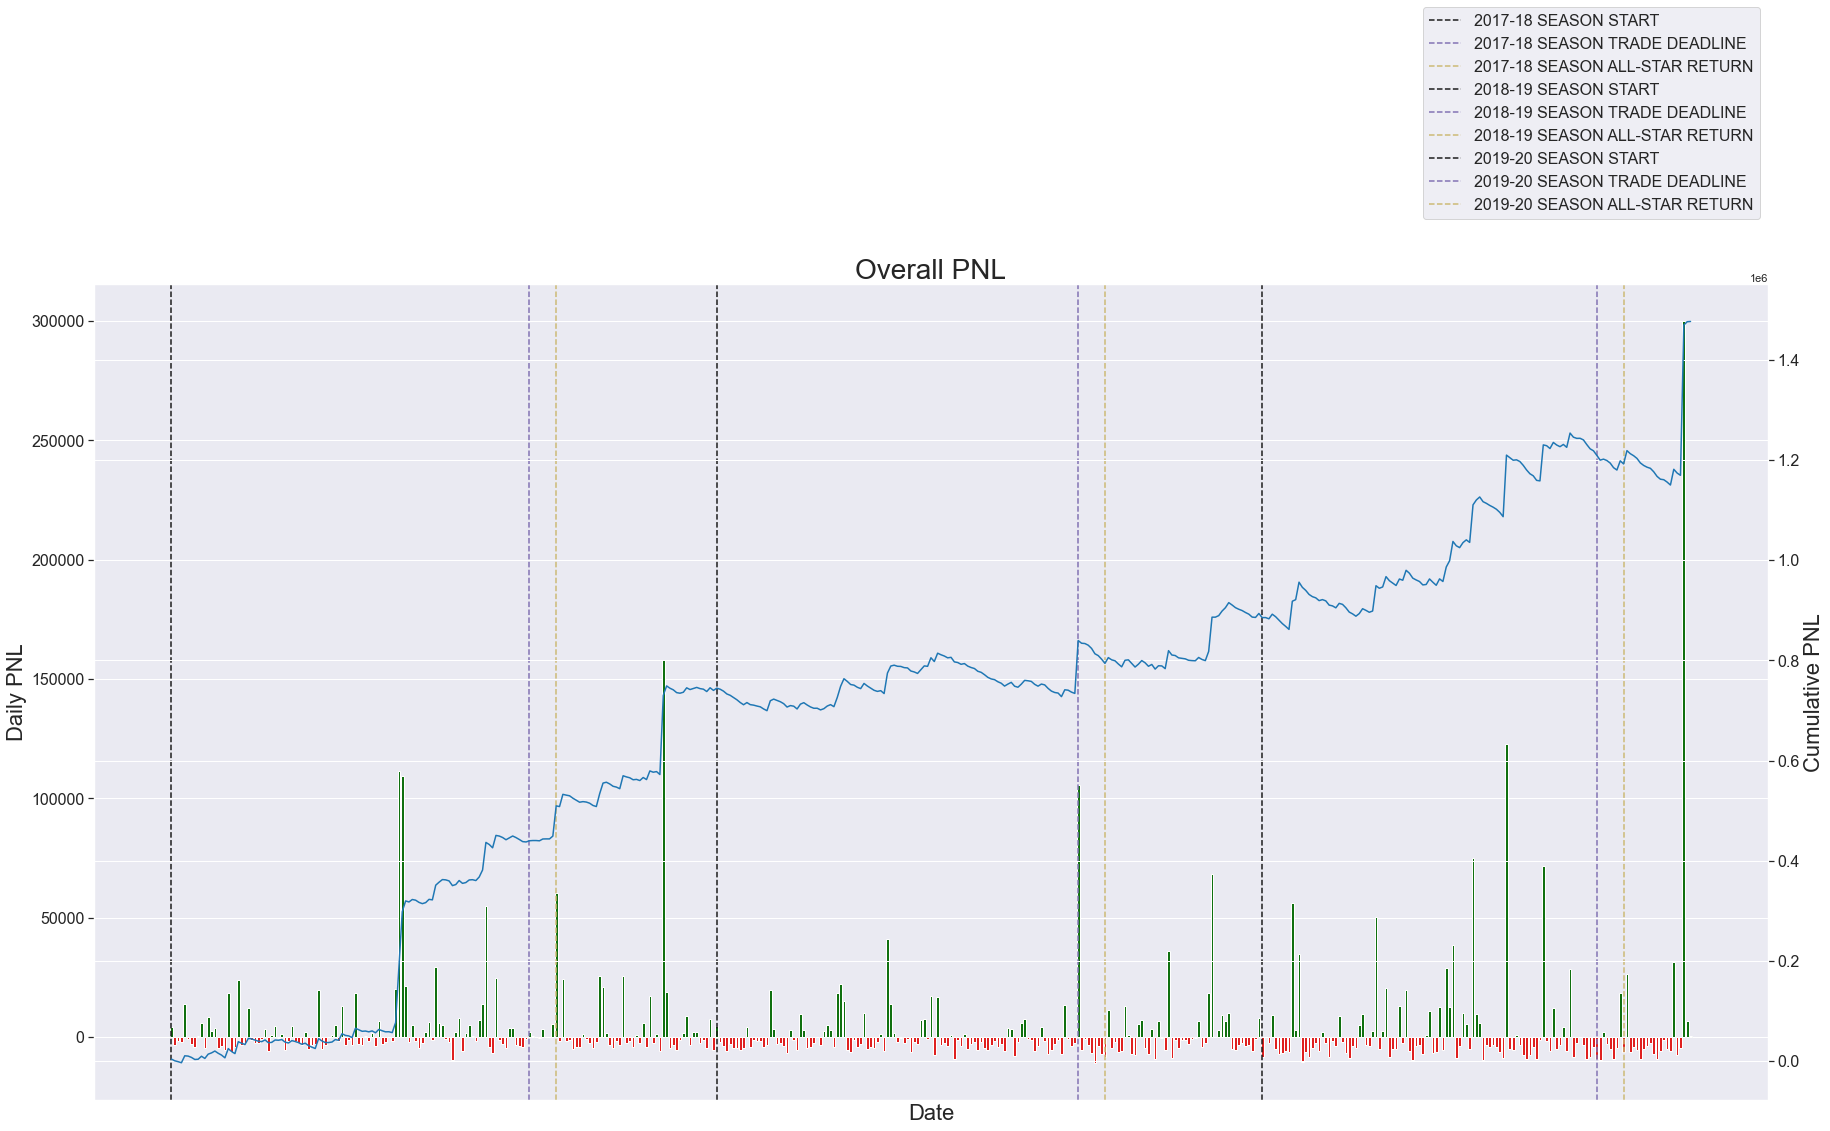

In [6]:
fig = plt.figure(1, figsize=(30, 15))

# overall PNL
temp = results.copy()
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Overall PNL', fontsize=28)

xcoords = {
    pnl.index.min(): ('2017-18 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2018-02-08'][0]: ('2017-18 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2018-02-22'][0]: ('2017-18 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2018-10-19'][0]: ('2018-19 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2019-02-07'][0]: ('2018-19 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2019-02-21'][0]: ('2018-19 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2019-10-25'][0]: ('2019-20 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2020-02-06'][0]: ('2019-20 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2020-02-20'][0]: ('2019-20 SEASON ALL-STAR RETURN', 'y'),
    
}
for xcoord in xcoords:
    ax1.axvline(x=xcoord, label=xcoords[xcoord][0], color=xcoords[xcoord][1], linestyle='dashed')
ax1.legend(bbox_to_anchor=(1, 1.35), loc='upper right', prop={'size': 16})

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=22)
ax1.set_ylabel('Daily PNL', fontsize=22)
ax2.set_ylabel('Cumulative PNL', fontsize=22)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

Break down ROI by contest type, entry fee, and number of games in the slate to determine where my projections generate the most return on investment.


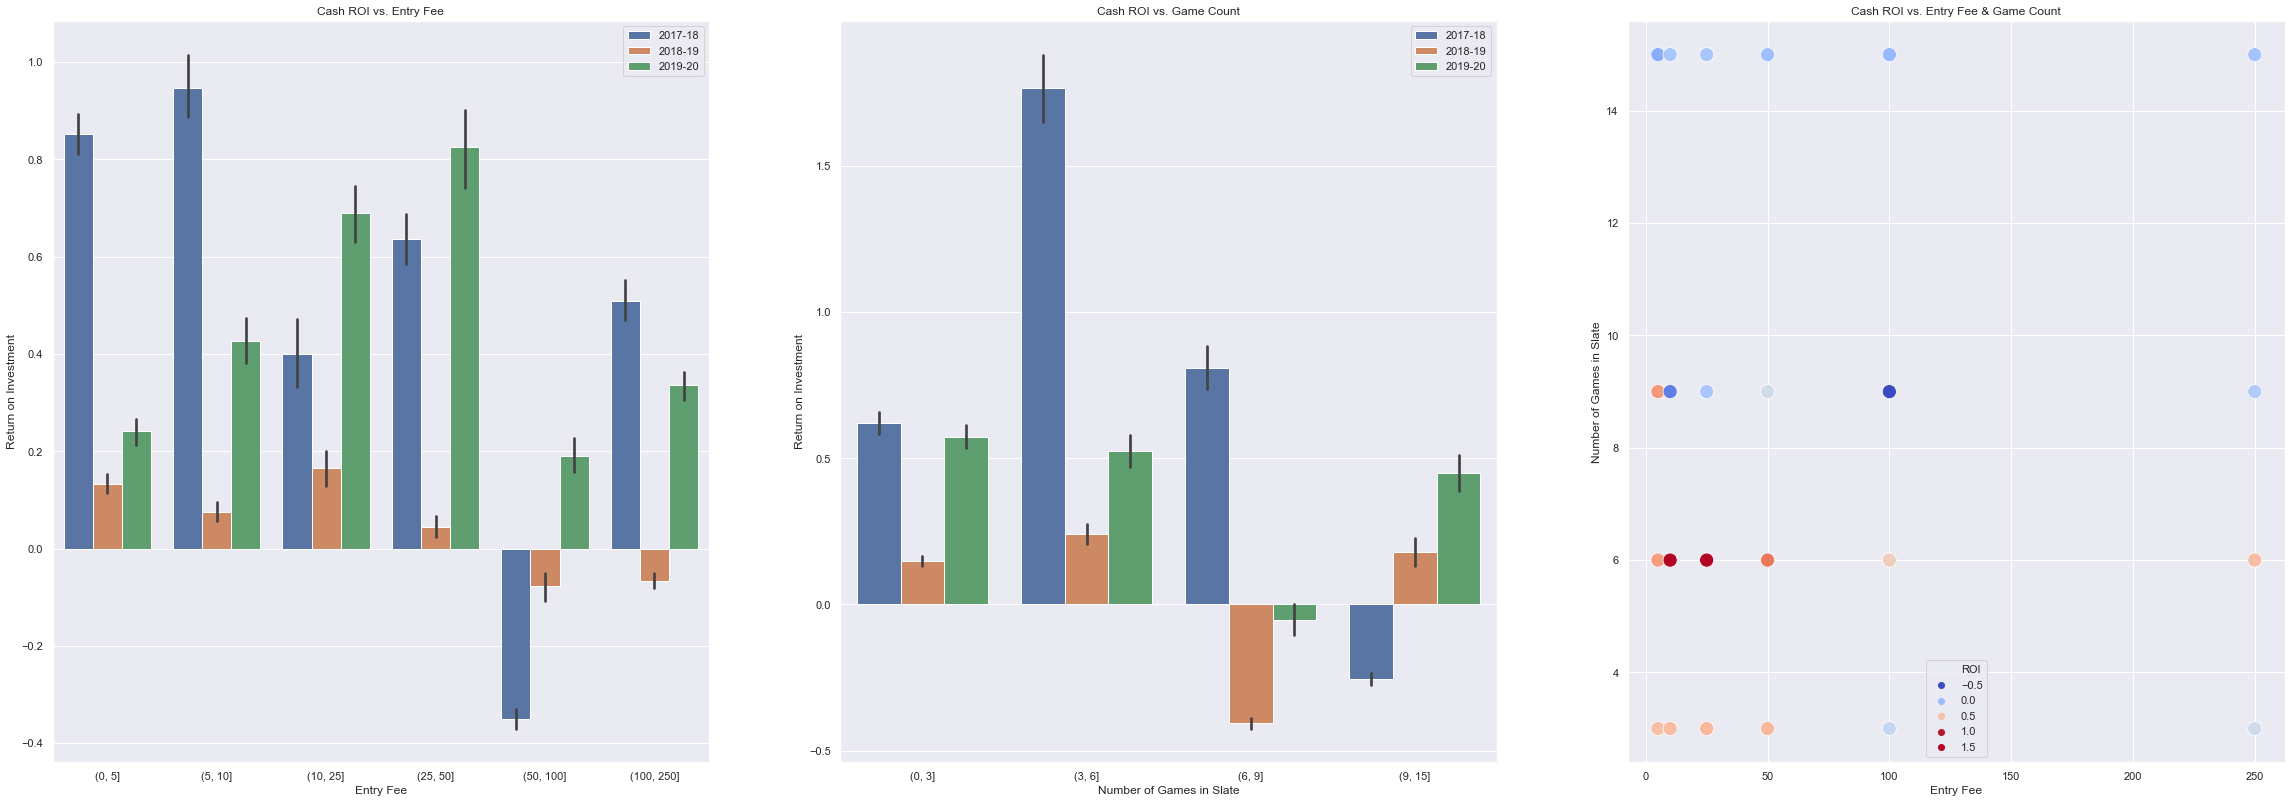

In [7]:
fig = plt.figure(1, figsize=(40, 30))
gs = fig.add_gridspec(2, 3)

# ROI vs. Entry Fee
temp = results.copy()
temp['ENTRY_BIN'] = pd.cut(temp['ENTRY_FEE'], bins=[0, 5, 10, 25, 50, 100, 250], duplicates='drop')
pnl = temp.groupby(['DATE', 'ENTRY_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(boxscores[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax4 = fig.add_subplot(gs[1, 0])
sns.barplot(x="ENTRY_BIN", y="ROI", hue="SEASON", data=pnl, ax=ax4)
ax4.set(xlabel="Entry Fee", ylabel="Return on Investment", title="Cash ROI vs. Entry Fee")
ax4.legend()

# ROI vs. Game Count
temp = results.copy()
temp['GAME_BIN'] = pd.cut(temp['GAME_COUNT'], bins=[0, 3, 6, 9, 15], duplicates='drop')
pnl = temp.groupby(['DATE', 'GAME_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(boxscores[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax5 = fig.add_subplot(gs[1, 1])
sns.barplot(x="GAME_BIN", y="ROI", hue="SEASON", data=pnl, ax=ax5)
ax5.set(xlabel="Number of Games in Slate", ylabel="Return on Investment", title="Cash ROI vs. Game Count")
ax5.legend()

# ROI vs. Entry Fee & Game Count
temp = results.copy()
temp['ENTRY_BIN'] = pd.cut(temp['ENTRY_FEE'], bins=[0, 5, 10, 25, 50, 100, 250], duplicates='drop')
temp['GAME_BIN'] = pd.cut(temp['GAME_COUNT'], bins=[0, 3, 6, 9, 15], duplicates='drop')
pnl = temp.groupby(['DATE', 'ENTRY_BIN', 'GAME_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(boxscores[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax6 = fig.add_subplot(gs[1, 2])
pnl['UPPER_ENTRY_FEE'] = pnl['ENTRY_BIN'].apply(lambda x: x.right)
pnl['UPPER_GAME_BIN'] = pnl['GAME_BIN'].apply(lambda x: x.right)
scat = pnl.groupby(['UPPER_GAME_BIN', 'UPPER_ENTRY_FEE']).apply(
    lambda x: pd.Series({
        'ROI': x['ROI'].mean()
    })
).reset_index()
sns.scatterplot(x='UPPER_ENTRY_FEE', y="UPPER_GAME_BIN", data=scat, hue='ROI', s=200, palette='coolwarm', ax=ax6)
ax6.set(xlabel="Entry Fee", ylabel="Number of Games in Slate", title="Cash ROI vs. Entry Fee & Game Count")
ax6.legend()

plt.show()

It is important not to overfit by cherry picking the contests in which the projections made money. To try to avoid this, I bucketed the entry fees and slate game counts. I will also only isolate a subset of contests if it makes sense why they were more profitable. The results above show that virtually no subset of cash games are profitable. On the other hand, tournaments whose entry fees are at most $1000 and slate game counts are at most 6 look profitable. This makes sense: higher entry contests attract more intelligent players, and high game slates introduce more variance.

Below I will graph the cumulative PNL of a strategy that only enters contests in the subset described above. I will also include cash games whose entry fees are at most $25 and slate game counts are at most 3 to verify the lack of edge.

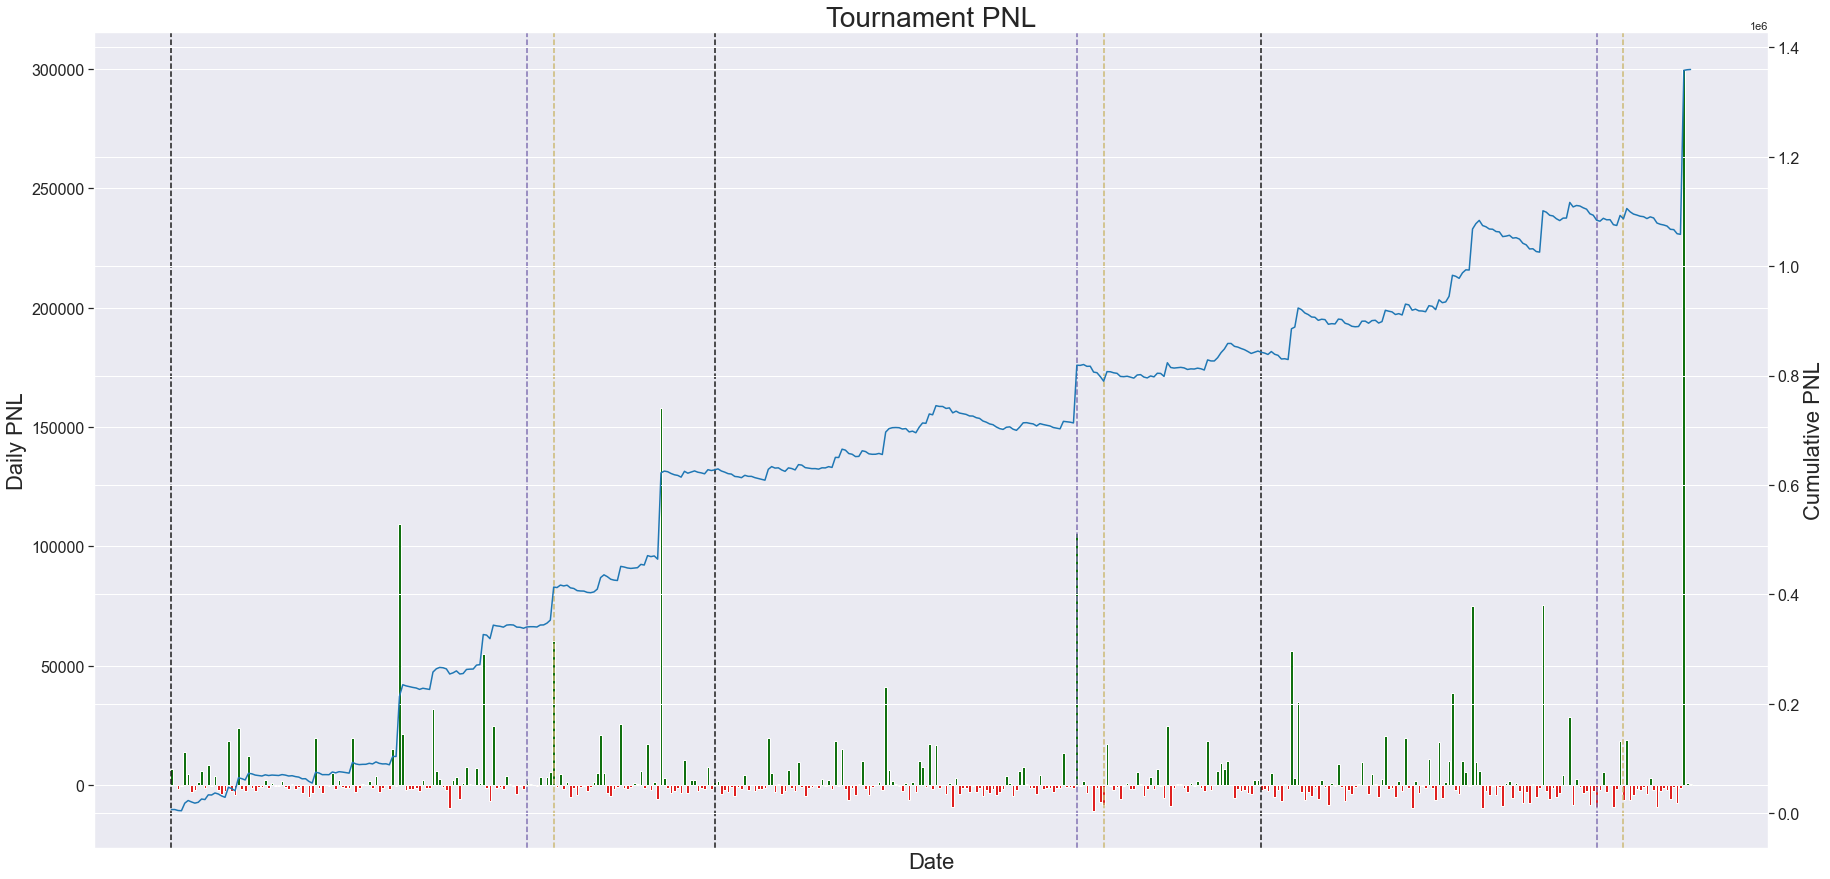

In [8]:
fig, plt.figure(1, figsize=(30, 15))

temp = results.loc[(results['GAME_COUNT'] <= 6)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Tournament PNL', fontsize=28)

xcoords = {
    pnl.index.min(): ('2017-18 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2018-02-08'][0]: ('2017-18 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2018-02-22'][0]: ('2017-18 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2018-10-19'][0]: ('2018-19 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2019-02-07'][0]: ('2018-19 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2019-02-21'][0]: ('2018-19 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2019-10-25'][0]: ('2019-20 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2020-02-06'][0]: ('2019-20 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2020-02-20'][0]: ('2019-20 SEASON ALL-STAR RETURN', 'y'),
    
}
for xcoord in xcoords:
    ax1.axvline(x=xcoord, color=xcoords[xcoord][1], linestyle='dashed')

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=22)
ax1.set_ylabel('Daily PNL', fontsize=22)
ax2.set_ylabel('Cumulative PNL', fontsize=22)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

I will only focus on tournament contests going forward. The tournament strategy seems like it may actually be profitable. However, there is a lot of variance in PNL, as the cumulative PNL depends entirely on a few days in which it hit big. Most days the strategy loses money, and there are some significant drawdowns.

Below shows the distribution of daily returns of this strategy.

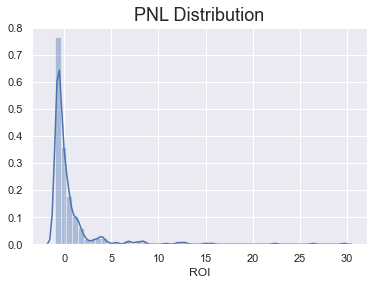

ROI Statistics:


count    454.000000
mean       0.587924
std        3.068753
min       -0.982756
25%       -0.653534
50%       -0.305537
75%        0.485094
max       29.706017
Name: ROI, dtype: float64

In [9]:
temp = results.loc[(results['GAME_COUNT'] <= 6)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['ROI'] = pnl['PNL']/pnl['ENTRY_FEE']
ax = sns.distplot(pnl['ROI'])
ax.set_title('PNL Distribution', fontsize=18)
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

print('ROI Statistics:')
pnl['ROI'].describe()

In [10]:
print(pnl['PRIZE'].mean())
print(pnl['ENTRY_FEE'].mean())

7558.0383920704835
4563.361894273128
